In [41]:
# Librerias usadas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [37]:
# Cargar data de archivo CSV
csv_file = 'data_ruido/datos_nodos2_202410161517.csv'
df = pd.read_csv(csv_file, sep='|')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Seleccionar columnas de interes
df_noise = df[['timestamp','id_wasp', 'sensor', 'value']]
print(f"Numero de datos en archivo '{csv_file}': {len(df_noise)}")
print(f"\nCabecera de DataFrame:\n {df_noise.head()}")
print(f"\nTipos de datos:\n {df_noise.dtypes}")

Numero de datos en archivo 'data_ruido/datos_nodos2_202410161517.csv': 15080

Cabecera de DataFrame:
             timestamp id_wasp sensor     value
0 2024-09-26 15:04:38   SCP01    BAT    100.00
1 2024-09-26 15:04:38   SCP01  NOISE     65.03
2 2024-09-26 15:04:38   SCP01     TC     24.54
3 2024-09-26 15:04:38   SCP01    HUM     36.70
4 2024-09-26 15:04:38   SCP01   PRES  75286.58

Tipos de datos:
 timestamp    datetime64[ns]
id_wasp              object
sensor               object
value               float64
dtype: object


In [57]:
# Select noise data
df_noise = df_noise[df_noise['sensor'] == 'NOISE']
print(f"Número de datos de ruido: {len(df_noise)}")
print(f"\nCabecera de datos de ruido:\n {df_noise.head()}")

Número de datos de ruido: 3016

Cabecera de datos de ruido:
              timestamp id_wasp sensor  value
1  2024-09-26 15:04:38   SCP01  NOISE  65.03
6  2024-09-26 15:15:18   SCP01  NOISE  65.37
11 2024-09-26 15:25:44   SCP01  NOISE  62.61
16 2024-09-26 15:36:10   SCP01  NOISE  53.10
21 2024-09-26 15:46:36   SCP01  NOISE  53.66


In [60]:
def draw_noise_line_chart(date:str, df_noise:pd.DataFrame, day_limit:float=0, night_limit:float=0):
    """ Dibuja un grafico de linea, dada una fecha. Ademas son necesarios los limites de dia y noche
    de ruido ambiente.

    Args:
        date (str): _description_
        df_noise (pd.DataFrame): _description_
        day_limit (float): _description_
        night_limit (float): _description_
    """
    # Seleccionar data del dia
    desired_date = pd.to_datetime(date).date()  
    df_noise_date = df_noise[df_noise['timestamp'].dt.date == desired_date]
    
    # Graficar datos seleccionados
    plt.figure(figsize=(10, 5))
    plt.plot(df_noise_date['timestamp'], df_noise_date['value'], label=df_noise_date.iloc[0]['id_wasp'], color='blue')

    # Agrega la línea vertical del limite TULSMA
    if day_limit > 0 and night_limit > 0:
        df_noise_limit = pd.DataFrame({
            'timestamp': [f'{date} 00:00:00', f'{date} 07:00:00', f'{date} 07:00:00', f'{date} 21:00:00', f'{date} 21:00:00', f'{date} 23:59:59'],
            'value': [night_limit, night_limit, day_limit, day_limit, night_limit, night_limit]
        })
        df_noise_limit['timestamp'] = pd.to_datetime(df_noise_limit['timestamp'])
        # Dibujar
        plt.plot(df_noise_limit['timestamp'], df_noise_limit['value'], label='Límite TULSMA', linestyle='--', color='red')


    # Configura el formato del eje X para mostrar solo la hora
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Agregar labels
    plt.title(f'Ruido registrado el {date}')
    plt.xlabel('Hora')
    plt.ylabel('Ruido')
    plt.legend()
    # plt.grid(True)

    # Mostrar el grafico
    plt.show

En el día 27 de septiembre se 

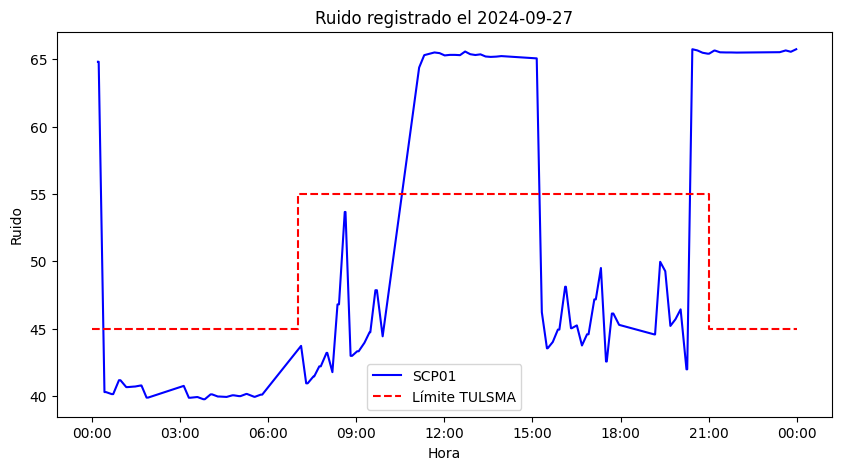

In [61]:
# Graficar ruido
draw_noise_line_chart(date='2024-09-27', df_noise=df_noise, day_limit=55, night_limit=45)